In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2020/unlabeled.csv
/kaggle/input/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv
/kaggle/input/widsdatathon2020/samplesubmission.csv
/kaggle/input/widsdatathon2020/solution_template.csv
/kaggle/input/widsdatathon2020/training_v2.csv


In [2]:
# ------------------------- IMPORTS -------------------------
!pip install pandas xgboost shap plotly numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import shap
from sklearn import metrics
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, roc_curve, auc
import plotly.express as px
from imblearn.over_sampling import RandomOverSampler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# ------------------------- DATA LOADING -------------------------
# loading dataset 
train = pd.read_csv("/kaggle/input/widsdatathon2020/training_v2.csv")

In [4]:
# ------------------------- DATA VISUALIZATION -------------------------

print("The original train dataframe shape is:")
print(train.shape)

df_missing_by_col = pd.DataFrame(train.isnull().sum(), columns=['total_na']).reset_index()
px.bar(df_missing_by_col[df_missing_by_col['total_na'] > 0], x='index', y='total_na', title="Columns with missing values:")


The original train dataframe shape is:
(91713, 186)


<AxesSubplot: >

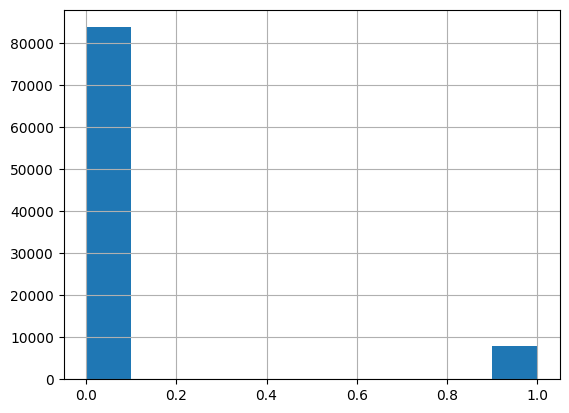

In [5]:
# plot the histogram of the target value
train['hospital_death'].hist()

The train dataframe shape after 'Drop columns with more than 50% missing data' is:
(91713, 112)


/tmp/ipykernel_20/1833820089.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_20/1833820089.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_20/1833820089.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_20/1833820089.py:49: SettingWithCopyWarning:


A value is trying

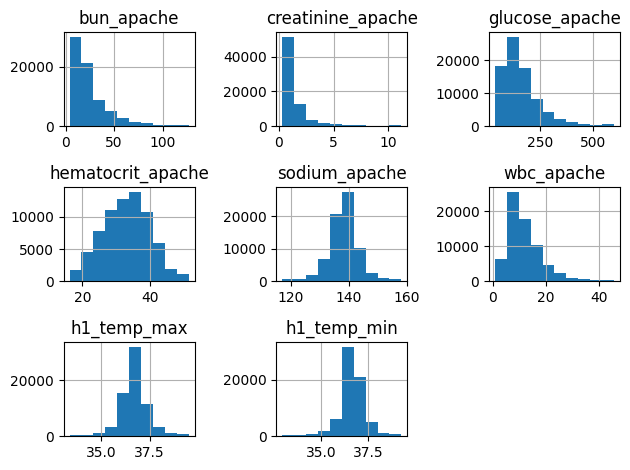

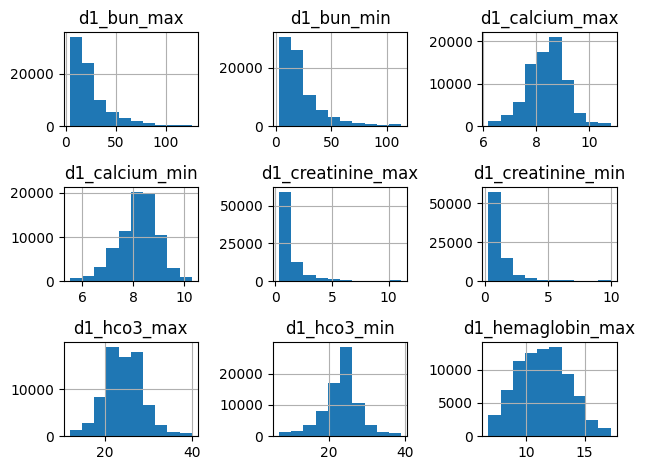

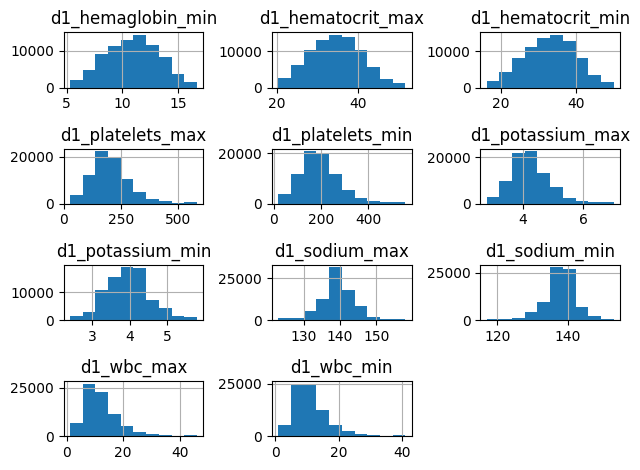

In [6]:
# ------------------------- DATA PREPROCESSING -------------------------

"""
The initial analysis included loading the training data and identifying the
 columns with missing values. Columns with more than 50% missing data were dropped.
  Histograms were plotted for numerical columns with more than 10% missing data to observe their distributions.
"""

# Drop columns with more than 50% missing data
thresh = len(train) * 0.5
train_df = train.dropna(axis=1, thresh=thresh)
print("The train dataframe shape after 'Drop columns with more than 50% missing data' is:")
print(train_df.shape)

# Find only numerical columns with more than 10% missing data
filtr = train_df.columns[train_df.isna().sum()>0.1*train_df.shape[0]]

# Impute missing values using mean or median strategy
mean_imp = SimpleImputer(missing_values = np.nan, strategy='mean')
med_imp = SimpleImputer(missing_values = np.nan, strategy='median')

_ = train_df[filtr[0:9].values].hist()
plt.tight_layout()
_ = train_df[filtr[9:18].values].hist()
plt.tight_layout()
_ = train_df[filtr[18:].values].hist()
plt.tight_layout()


"""
The features bun_apache, creatinine, glucose_apache, wbc_apache, d1_bun_max, d1_bun_min, d1_creatinine_min, 
and d1_creatinine_max are assumed to have a normal distribution. Therefore, we replace their missing values with the mean
value, as it is a representative measure for normally distributed data.
As for the other features, which do not follow a normal distribution,
we use the median value to impute missing values. The median is a suitable measure of central tendency for non-normally 
distributed data, as it is less affected by outliers.
"""

filtr2 = ['bun_apache', 'creatinine_apache', 'd1_bun_min', 'd1_creatinine_max','d1_creatinine_min']
filtr = filtr.drop('hospital_admit_source')   
filtr = filtr.drop(filtr2)
train_df[filtr] = mean_imp.fit_transform(train_df[filtr])
train_df[filtr2] = med_imp.fit_transform(train_df[filtr2])

# Fill missing values in 'hospital_admit_source' column with the method 'bfill'
train_df['hospital_admit_source'].fillna(method='bfill', inplace=True)

# Drop remaining missing values
train_df.dropna(inplace=True)

X = train_df.drop("hospital_death", axis=1)
y = train_df["hospital_death"]


'''
Missing values in numerical features were imputed using either mean or median strategies
 based on the distributions of the data. Features with normal distributions were imputed
  with the mean, and the rest were imputed with the median.
   After imputing, any remaining missing values were dropped.
'''

numerical_features = X.select_dtypes(include=["int", "float"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns


'''
Categorical features were one-hot encoded.
 Numerical features were binned into 3 categories 
 using uniform strategy with the exception of 'id' related features
'''
# Encode categorical features using One-Hot-Encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

'''
Three new features were created based on existing ones:

'renal_function': by dividing 'bun_apache' by 'creatinine_apache',
'neuro_function': by taking the average of 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache',
'cardio_function': by multiplying 'heart_rate_apache' and 'map_apache' and then dividing by 'hematocrit_apache'.
'''

#renal function: dividing the value of bun_apache (blood urea nitrogen) by creatinine_apache, which are both indicators of renal function.
X['renal_function'] = X['bun_apache'] / X['creatinine_apache']

# Neurological function: taking the average of the values of gcs_eyes_apache, gcs_motor_apache, and gcs_verbal_apache, 
# which are components of the Glasgow Coma Scale and are used to evaluate neurological function.
X['neuro_function'] = (X['gcs_eyes_apache'] + X['gcs_motor_apache'] + X['gcs_verbal_apache']) / 3

# Cardiovascular function: multiplying the values of heart_rate_apache and map_apache 
# and then dividing by hematocrit_apache, which are all indicators of cardiovascular function.
X['cardio_function'] = (X['heart_rate_apache'] * X['map_apache']) / X['hematocrit_apache']
numerical_features.append(pd.Index(['cardio_function', 'neuro_function', 'renal_function']))


# Apply binning to numerical features (excluding those with "id" in their names)
non_id_numerical_features = [feature for feature in numerical_features if "id" not in feature]
binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X[non_id_numerical_features] = binning.fit_transform(X[non_id_numerical_features])

**Show that there are no Nan's.**

<AxesSubplot: >

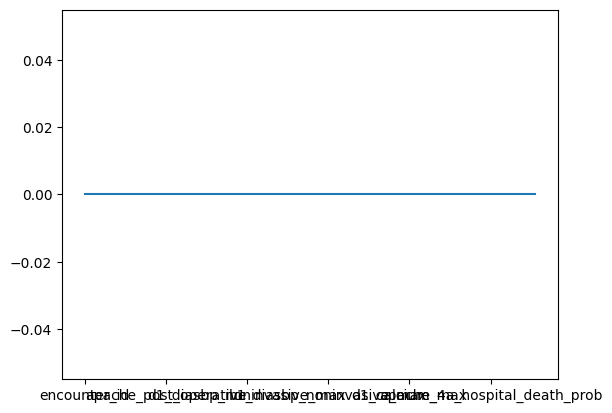

In [7]:
train_df.isna().sum().plot()

**The data is imbalance, we should balance the data for more accurate results**

In [8]:
ros = RandomOverSampler(sampling_strategy=0.6)
X,y = ros.fit_resample(X,y)

<AxesSubplot: >

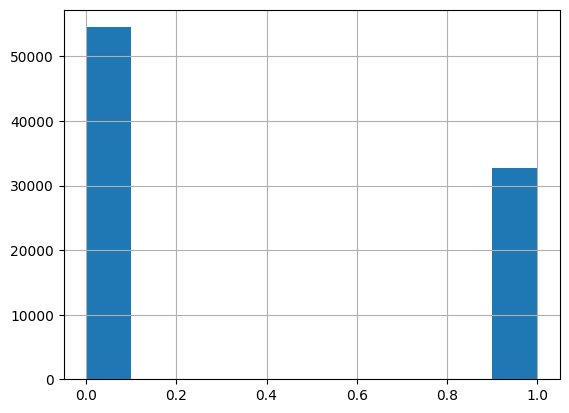

In [9]:
y.hist()

**Feature selection using SHAP**

100%|===================| 87058/87232 [07:35<00:00]       /tmp/ipykernel_20/67394120.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



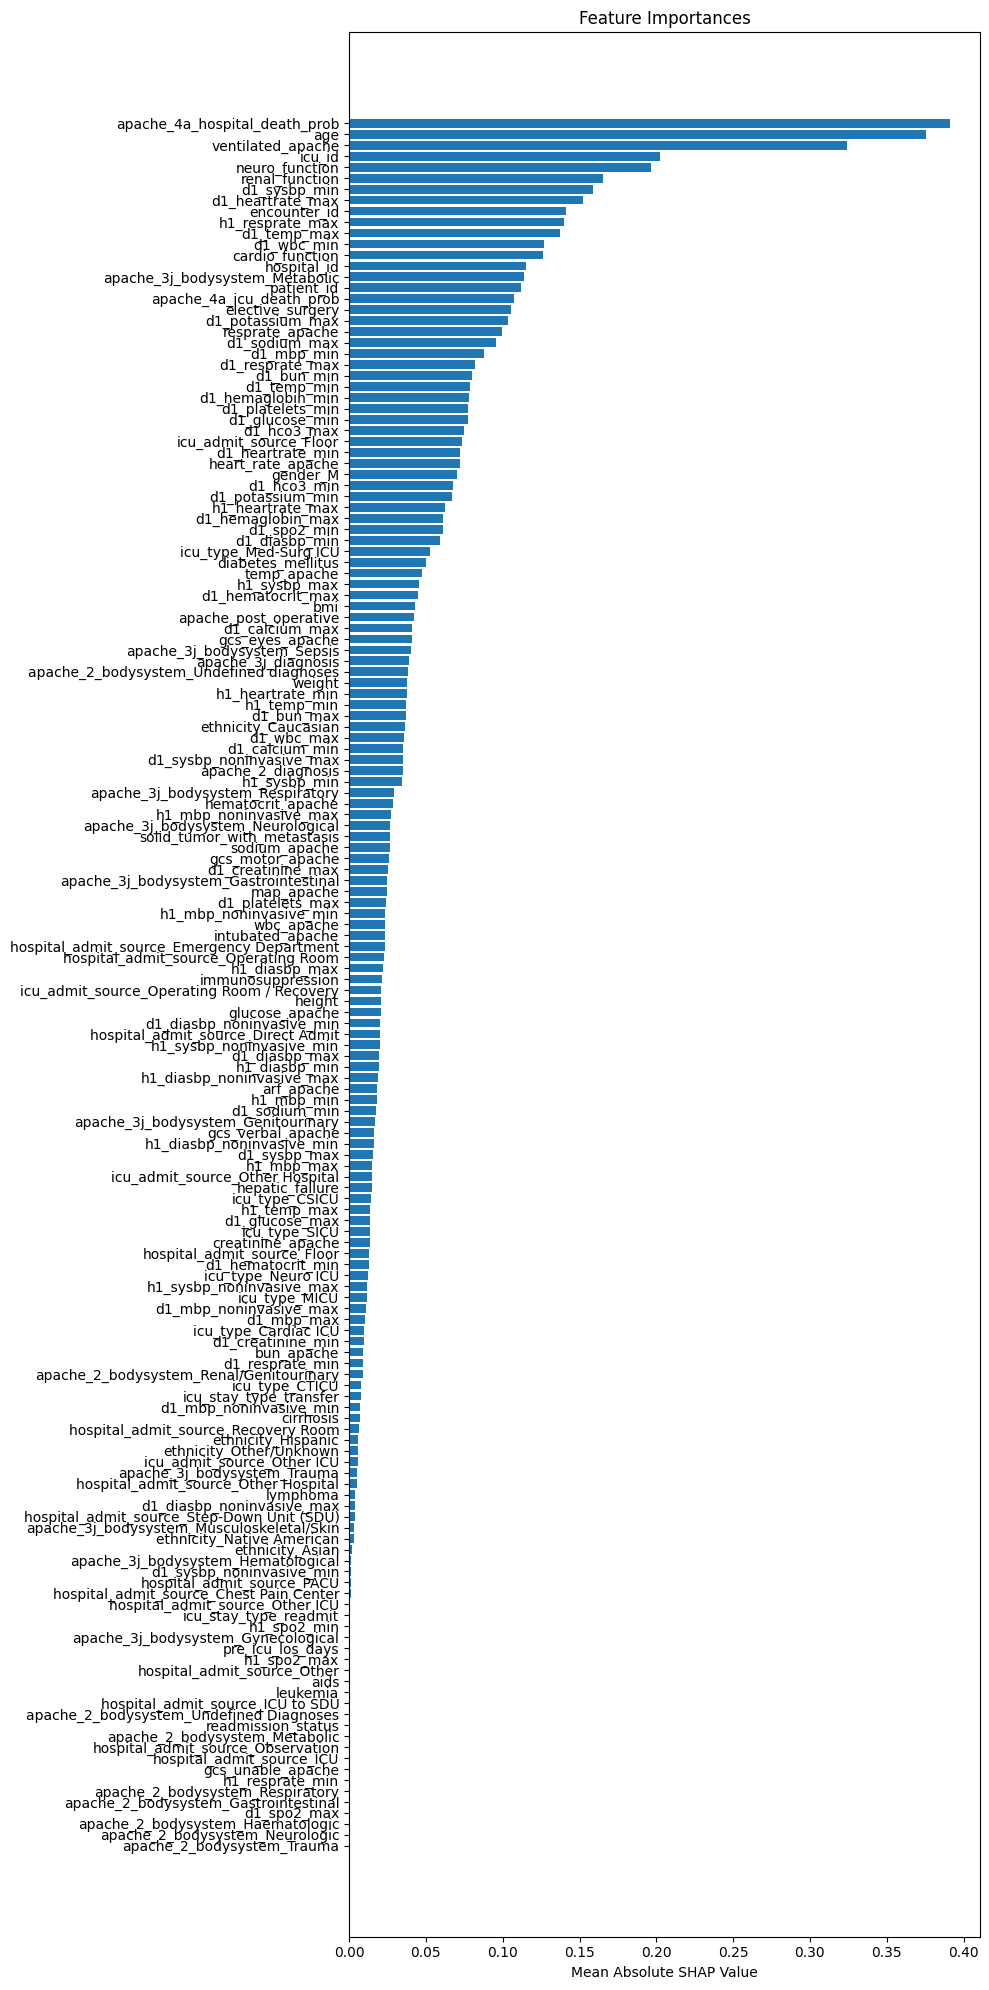

In [10]:
## ------------------------- FEATURE ENGINEERING -------------------------

'''
A method called SHAP (SHapley Additive exPlanations) was used to
identify the most relevant features. SHAP calculates the contribution of each feature to the prediction for each instance.
 Features were ranked by the mean absolute SHAP value, and the top 50% of features were selected for further processing.
'''
model = xgb.XGBClassifier(random_state=42, enable_categorical=True, tree_method='hist')
model.fit(X, y)
explainer = shap.Explainer(model, X)
shap_values = explainer.shap_values(X)
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
num_features = int(X.shape[1] * 0.5)
top_feature_indices = mean_abs_shap_values.argsort()[-num_features:]
X_selected = X.iloc[:, top_feature_indices]
X_selected["hospital_death"] = y

# Plot feature importances
# Sort the features by importance
sorted_indices = mean_abs_shap_values.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 20))
plt.barh(range(X.shape[1]), mean_abs_shap_values[sorted_indices], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_indices])
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Save the processed DataFrame to a CSV file
X_selected.to_csv("after_preproccess.csv", index=False)

**Grid search to find the best estimators for each classifier**

In [11]:
# ------------------------- MODEL TRAINING -------------------------

'''
Five classification models were used:

AdaBoost Classifier
Random Forest Classifier
Gaussian Naive Bayes
XGBoost Classifier
Decision Tree Classifier
For each classifier, a grid search was performed with cross-validation to tune their hyperparameters and find the best model based on the recall score. Then, an XGBoost model was further tuned and evaluated based on the accuracy score. The final model was trained using the best parameters obtained from grid search and saved for future use.

'''

# Separate the features (X) and the target variable (y)
X = X_selected.drop("hospital_death", axis=1)
y = X_selected["hospital_death"]

# Define the models
naive_bayes_model = GaussianNB()
tree_model = DecisionTreeClassifier()
ada_model = AdaBoostClassifier()
rf_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier(enable_categorical=True, tree_method='hist')


# define hyperparameters to search for each classifier
naive_bayes_params = {'var_smoothing': [1e-09, 1e-08, 1e-07]}
tree_params = {'max_depth': [3, 4, 5, 6, 7]}
ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0], 'algorithm': ['SAMME', 'SAMME.R']}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
xgb_params = {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200, 300, 500]}

# create a list of classifiers
classifiers = [ada_model, rf_model, naive_bayes_model, xgb_model, tree_model]

# create a list of classifier names
classifier_names = ['ADAboost', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Decision Tree']

# create a list of parameter grids
params_list = [ada_params, rf_params, naive_bayes_params, xgb_params, tree_params]

# create an empty list to hold the best classifiers and their results
best_classifiers = []
best_results = []

## !!!!ADD decsiption why we choosed recall as the scoring method!!!!

# iterate over each classifier and its corresponding parameter grid
for classifier, params in zip(classifiers, params_list):
    start_time = time.time()
    # create a GridSearchCV instance for the current classifier and its parameter grid
    grid_search = GridSearchCV(classifier, params, cv=10, scoring='recall')
    
    # perform the grid search on the dataset
    grid_search.fit(X, y)
    
    # store the best classifier and its results in the lists
    best_classifiers.append(grid_search.best_estimator_)
    best_results.append(grid_search.best_score_)
    
    end_time = time.time()
    # print the best parameters and results for the current classifier
    print(classifier_names[classifiers.index(classifier)])
    print(grid_search.best_params_)
    print('Best Recall:', grid_search.best_score_)
    print(f'Gridsearch time: {end_time - start_time} seconds')
    print('---')

ADAboost
{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
Best Recall: 0.6774280481433117
Gridsearch time: 4097.614595651627 seconds
---
Random Forest
{'max_depth': 7, 'n_estimators': 100}
Best Recall: 0.57893084481765
Gridsearch time: 786.2767424583435 seconds
---
Naive Bayes
{'var_smoothing': 1e-09}
Best Recall: 0.4360484800487951
Gridsearch time: 5.524846076965332 seconds
---
XGBoost
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best Recall: 0.9777764738507397
Gridsearch time: 1233.4471790790558 seconds
---
Decision Tree
{'max_depth': 7}
Best Recall: 0.6324281733452232
Gridsearch time: 43.33360004425049 seconds
---


In [12]:
# ------------------------- MODEL Evaluation -------------------------

def cross_val_predict(model, k_fold_splits, X, y):
    """
    fit model with k fold splits and return the actual values and the predicted values for all the test data
    :param model: the model to fit the data on
    :param k_fold_splits: the number of cross fold validations
    :param data: the dataset with all the features and the target
    :param drop_columns: array of column names to drop from the dataset
    :param target_column: the name of the target column
    :return: tuple of the actual values and the predicted values
    """

    actual_values = np.empty([0], dtype=int)
    predicted_values = np.empty([0], dtype=int)

    for i in range(k_fold_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        actual_values = np.append(actual_values, y_test)
        model.fit(X_train, y_train)
        predicted_values = np.append(predicted_values, model.predict(X_test))
    return actual_values, predicted_values

def print_classifier_metrics(actual_values, predicted_values):
    """
    prints the mae and mse metrics for the trained model
    :param actual_values: nd array of actual values of all the test sets
    :param predicted_values: nd array of predicted values of all the test sets
    """
    auc = metrics.roc_auc_score(actual_values, predicted_values)
    print('area under ROC curve:', auc)
    print("\n")
    accuracy = metrics.accuracy_score(actual_values, predicted_values)
    print('Accuracy:', accuracy)
    print("\n")
    recall = metrics.recall_score(actual_values, predicted_values)
    print('Recall:', recall)
    print("\n")
    precision = metrics.precision_score(actual_values, predicted_values)
    print('Precision:', precision)
    print("\n\n")

def plot_confusion_matrix(actual_values, predicted_values):
  cm = metrics.confusion_matrix(actual_values, predicted_values)
  # Plot the confusion matrix
  plt.imshow(cm, cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()
    
def plot_roc_curve(actual_values, predicted_values):
    fpr, tpr, thresholds = roc_curve(actual_values, predicted_values)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


**Evaluation metrics for each classifier with the best hyper-parameters found** 

ADAboost
-------------------

area under ROC curve: 0.7758897630463576


Accuracy: 0.8030218268525312


Recall: 0.6680144581265699


Precision: 0.7746298769571766



Confusion matrix:


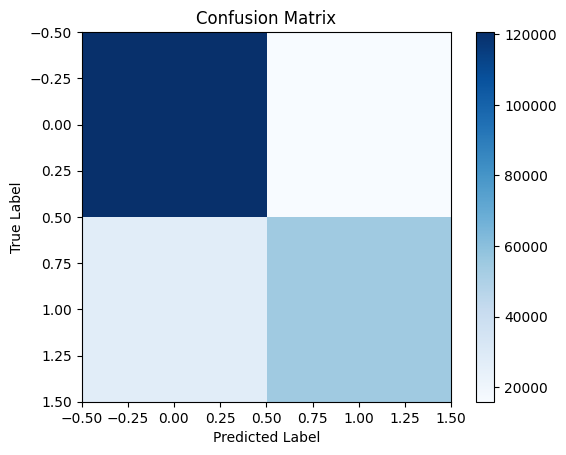

Roc curve:


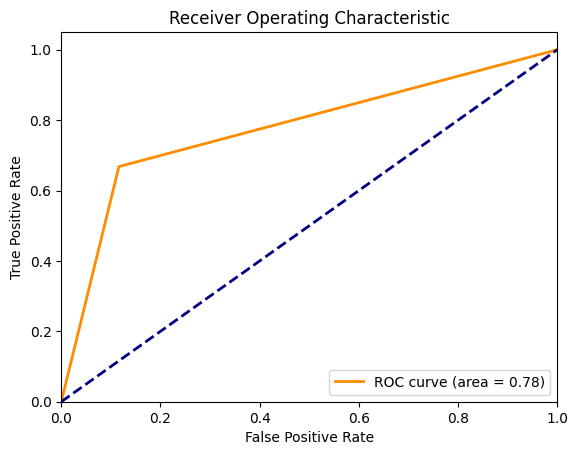

evaluation time: 337.6690697669983sec


Random Forest
-------------------

area under ROC curve: 0.7494433103601057


Accuracy: 0.7927182685253118


Recall: 0.5755588928366482


Precision: 0.8186728261058335



Confusion matrix:


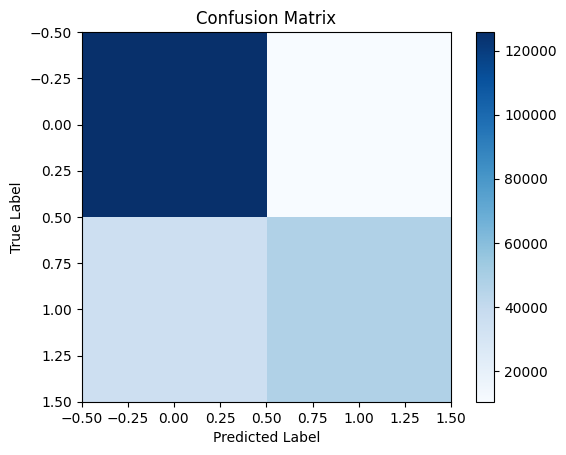

Roc curve:


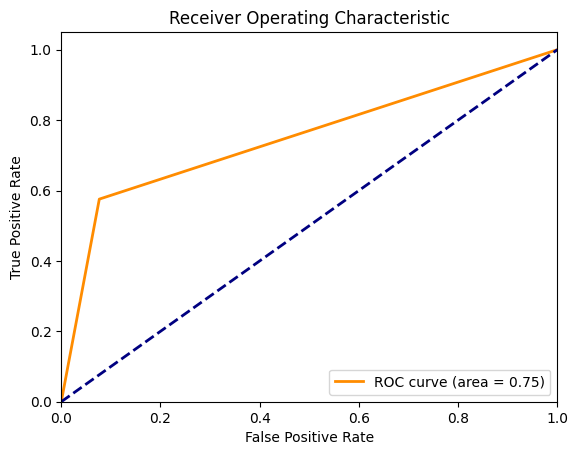

evaluation time: 43.898167848587036sec


Naive Bayes
-------------------

area under ROC curve: 0.6811329701929943


Accuracy: 0.7426128026412325


Recall: 0.43704030597234483


Precision: 0.777426459364574



Confusion matrix:


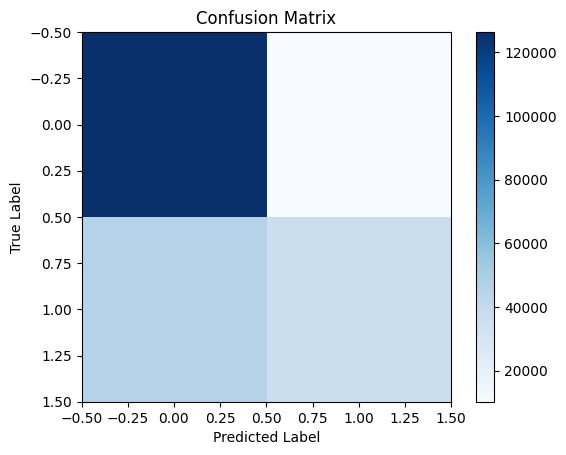

Roc curve:


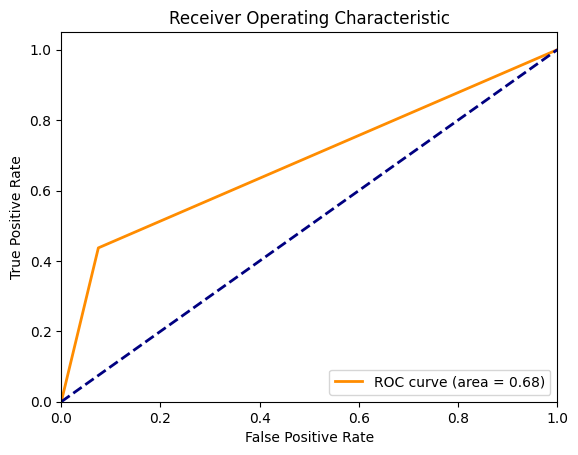

evaluation time: 2.84565806388855sec


XGBoost
-------------------

area under ROC curve: 0.95769887367323


Accuracy: 0.9556584739545121


Recall: 0.9657736816915582


Precision: 0.9195947603968263



Confusion matrix:


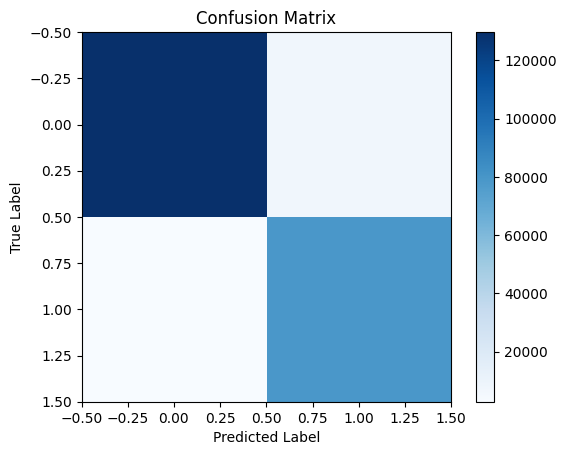

Roc curve:


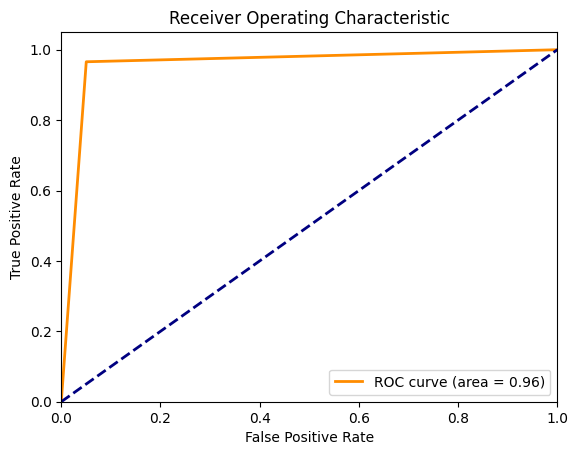

evaluation time: 809.625702381134sec


Decision Tree
-------------------

area under ROC curve: 0.758636189400627


Accuracy: 0.7903292369772561


Recall: 0.6301865199181845


Precision: 0.7712744557524102



Confusion matrix:


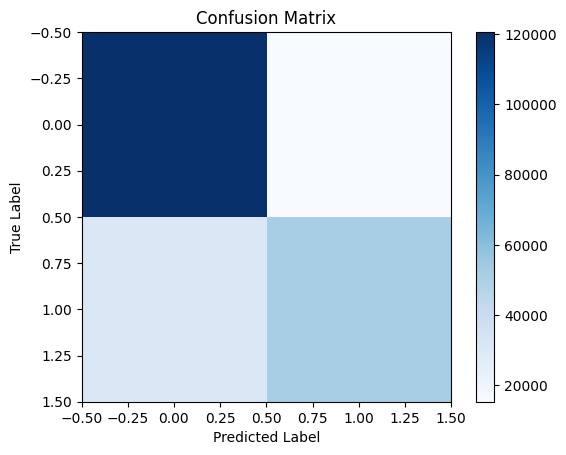

Roc curve:


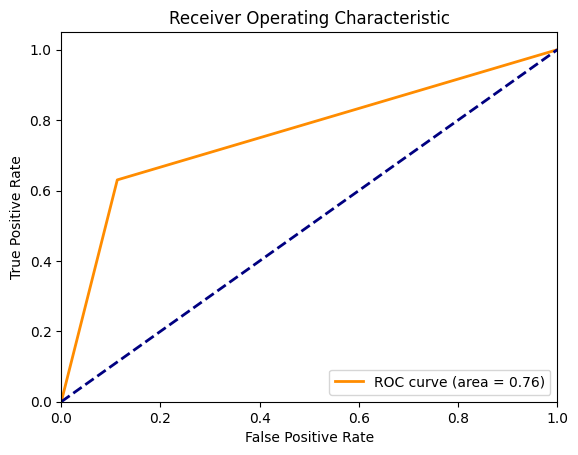

evaluation time: 10.743642807006836sec




In [13]:
# create an instance of each classifier using the best params.

naive_bayes_model = GaussianNB(var_smoothing =  1e-09)
tree_model = DecisionTreeClassifier(max_depth = 7)
ada_model = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = 1.0, n_estimators = 200)
rf_model = RandomForestClassifier(max_depth = 7, n_estimators=  50)
xgb_model = xgb.XGBClassifier(learning_rate = 0.1, max_depth =  7, n_estimators =  500)

# create a list of classifiers
classifiers = [ada_model, rf_model, naive_bayes_model, xgb_model, tree_model]

# create a list of classifier names
classifier_names = ['ADAboost', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Decision Tree']

for classifier in classifiers:
    # print the best parameters and results for the current classifier
    print(classifier_names[classifiers.index(classifier)])
    print("-------------------\n")
    start_time = time.time()
    actual_values, predicted_values = cross_val_predict(classifier, 10, X, y)
    print_classifier_metrics(actual_values, predicted_values)
    print("Confusion matrix:")
    plot_confusion_matrix(actual_values, predicted_values)
    print("Roc curve:")
    plot_roc_curve(actual_values, predicted_values)
    end_time = time.time()
    print("evaluation time: " + str(end_time - start_time) + "sec\n\n")

**Preproccess for the unlabaled data**

In [14]:
# ------------------------- UNLABLED Data PREPROCESSING -------------------------

test = pd.read_csv("/kaggle/input/widsdatathon2020/unlabeled.csv")

test.drop('hospital_death', axis=1, inplace=True)

# Impute missing values using mean or median strategy
mean_imp = SimpleImputer(missing_values = np.nan, strategy='mean')
med_imp = SimpleImputer(missing_values = np.nan, strategy='median')

# We are using filter and filtr2 from the training pre-processing
test[filtr] = mean_imp.fit_transform(test[filtr])
test[filtr2] = med_imp.fit_transform(test[filtr2])

'''
Missing values in numerical features were imputed using either mean or median strategies
 based on the distributions of the data. Features with normal distributions were imputed
  with the mean, and the rest were imputed with the median.
   After imputing, any remaining missing values were dropped.
'''

numerical_features = test.select_dtypes(include=["int", "float"]).columns
categorical_features = test.select_dtypes(include=["object"]).columns

'''
Categorical features were one-hot encoded.
 Numerical features were binned into 3 categories 
 using uniform strategy with the exception of 'id' related features
'''
# Encode categorical features using One-Hot-Encoding
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

'''
Three new features were created based on existing ones:

'renal_function': by dividing 'bun_apache' by 'creatinine_apache',
'neuro_function': by taking the average of 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache',
'cardio_function': by multiplying 'heart_rate_apache' and 'map_apache' and then dividing by 'hematocrit_apache'.
'''

#renal function: dividing the value of bun_apache (blood urea nitrogen) by creatinine_apache, which are both indicators of renal function.
test['renal_function'] = test['bun_apache'] / test['creatinine_apache']

# Neurological function: taking the average of the values of gcs_eyes_apache, gcs_motor_apache, and gcs_verbal_apache, 
# which are components of the Glasgow Coma Scale and are used to evaluate neurological function.
test['neuro_function'] = (test['gcs_eyes_apache'] + test['gcs_motor_apache'] + test['gcs_verbal_apache']) / 3

# Cardiovascular function: multiplying the values of heart_rate_apache and map_apache 
# and then dividing by hematocrit_apache, which are all indicators of cardiovascular function.
test['cardio_function'] = (test['heart_rate_apache'] * test['map_apache']) / test['hematocrit_apache']
numerical_features.append(pd.Index(['cardio_function', 'neuro_function', 'renal_function']))

#Get feature names from the training data
train_features = X.columns.tolist()

# Drop extra columns from unlabeled data
for column in test.columns:
    if column not in train_features:
        test.drop(column, axis=1, inplace=True)

# Drop extra columns from numerical_features data
for column in numerical_features:
    if column not in train_features:
        numerical_features = numerical_features.drop(column)

test.fillna(method='bfill', inplace=True)
test.fillna(method='ffill', inplace=True)

# Apply binning to numerical features (excluding those with "id" in their names)
non_id_numerical_features = [feature for feature in numerical_features if "id" not in feature]
binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
test[non_id_numerical_features] = binning.fit_transform(test[non_id_numerical_features])

**Show that there are no Nan's.**

<AxesSubplot: >

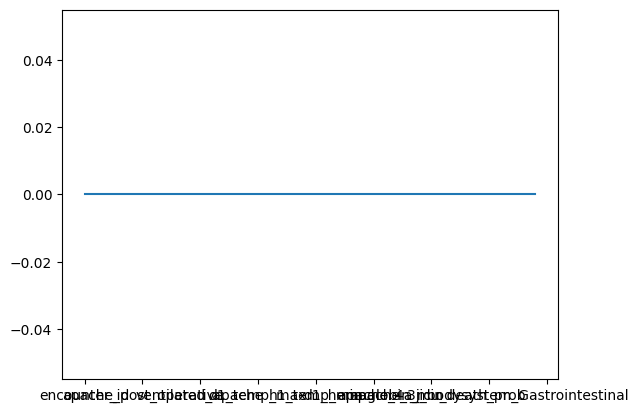

In [15]:
test.isna().sum().plot()

In [16]:
test = test[train_features]

solution_ada = ada_model.predict(test)
solution_xgb = xgb_model.predict(test)

In [17]:
print(solution_ada)
print(solution_xgb)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [18]:
test_ans_ada_model = pd.read_csv("/kaggle/input/widsdatathon2020/unlabeled.csv")
test_ans_xgb_model = pd.read_csv("/kaggle/input/widsdatathon2020/unlabeled.csv")

test_ans_ada_model['hospital_death'] = solution_ada
test_ans_xgb_model['hospital_death'] = solution_xgb

test_ans_ada_model = test_ans_ada_model[['encounter_id', 'hospital_death']]
test_ans_xgb_model = test_ans_xgb_model[['encounter_id', 'hospital_death']]

**ADABoost results**

       encounter_id  hospital_death
0                 2               0
1                 5               0
2                 7               0
3                 8               0
4                10               0
...             ...             ...
39303        131035               0
39304        131037               0
39305        131039               0
39306        131041               0
39307        131050               0

[39308 rows x 2 columns]


<AxesSubplot: >

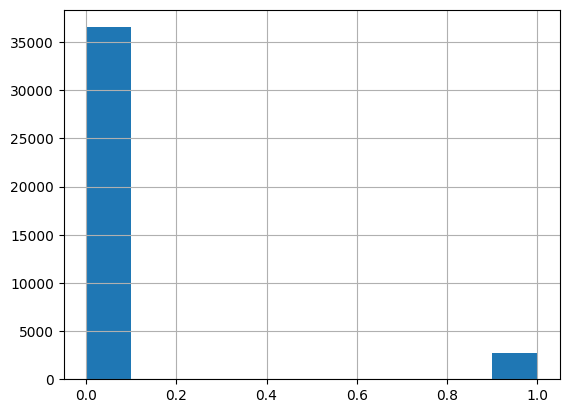

In [19]:
print(test_ans_ada_model)
test_ans_ada_model['hospital_death'].hist()

**XGBoost results**

       encounter_id  hospital_death
0                 2               0
1                 5               0
2                 7               0
3                 8               0
4                10               0
...             ...             ...
39303        131035               0
39304        131037               0
39305        131039               0
39306        131041               0
39307        131050               0

[39308 rows x 2 columns]


<AxesSubplot: >

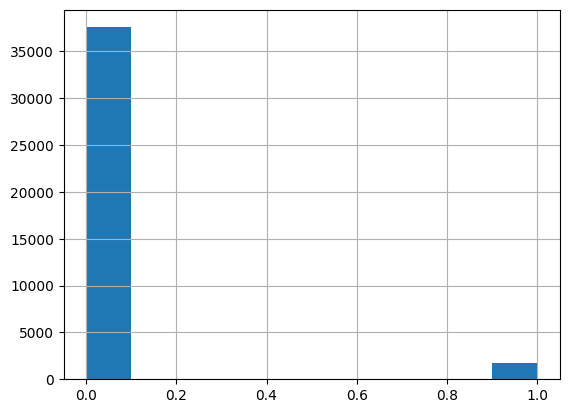

In [20]:
print(test_ans_xgb_model)
test_ans_xgb_model['hospital_death'].hist()

**save solutions**

In [21]:
#test_ans_ada_model.to_csv("submission_ADABoost_solution.csv", index=False)
test_ans_xgb_model.to_csv("submission.csv", index=False)

In [22]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)